# Poisson Pressure Solver

Let $(x,y,z)\in[x_{\text{min}}, x_{\text{max}}]\times[y_{\text{min}}, y_{\text{max}}]\times[z_{\text{min}}, z_{\text{max}}]=[0, 2\pi]^3=\Omega$, 
then the Poisson's problem is defined as
\begin{equation}
    \begin{split}
        \nabla^2p(x,y,z) &= \left(\dfrac{\partial^2}{\partial x^2} + \dfrac{\partial^2}{\partial y^2} + \dfrac{\partial^2}{\partial z^2}\right)p(x,y,z) 
            = f(x,y,z) \quad \text{in} ~ \Omega,\\
        \frac{\partial p}{\partial z} &=0, \quad \text{on} ~ z=z_{\text{min}}, \\
        p &= 0, \quad \text{on} ~ z=z_{\text{max}},
    \end{split}
\end{equation}

with periodic boundary conditions in $x$ and $y$ directions, and

\begin{equation}
    f(x,y,z) = \frac{1}{\pi^3}
        \left[
            \left(z^3-2\pi z^2\right)
            \left(
            \dfrac{2}{s_x}\left(1-\dfrac{2}{s_x}(x-x_0)^2\right) + 
            \dfrac{2}{s_y}\left(1-\dfrac{2}{s_y}(y-y_0)^2\right)
            \right) 
            + g(z)
        \right]
        G(x,y,z),
\end{equation}

with

\begin{equation*}
    G(x,y,z)=\exp\left(-\left(\frac{(x - x_0)^2}{s_x} + \frac{(y - y_0)^2}{s_y}+ \frac{(z - z_0)^2}{s_z}\right)\right),
\end{equation*}

and

\begin{equation*}
    g(z) = -\dfrac{4}{s_z}z^5+\left(\dfrac{8\pi  + 8z_0}{s_z^2}\right)z^4 - 
        \left(\dfrac{16\pi z_0 + 4z_0^2-14s_z}{s_z^2}\right)z^3 + \\
        \left(\dfrac{8\pi z_0^2 - 12s_zz_0 - 20\pi s_z}{s_z^2}\right)z^2 + \left(\dfrac{16\pi z_0 - 6s_z}{s_z}\right)z + 4\pi
\end{equation*}

The solution of this problem is
\begin{equation}
    p(x,y,z) = \frac{1}{\pi^3}(2\pi z^2-z^3)\,G(x,y,z).
\end{equation}

We use $x_0=y_0=z_0=\pi$, and $s_x=s_y=s_z=.5$.

In [1]:
import time as time
from fftfd import *

In [2]:
x0 = y0 = z0 = np.pi 
sx = sy = sz = .5

In [3]:
# Functions
G = lambda x, y, z: np.exp(-((x - x0) ** 2 / sx + (y - y0) ** 2 / sy + (z - z0) ** 2 / sz))
g = lambda z: -4 * z ** 5 / sz ** 2 + (8 * np.pi + 8 * z0) * z ** 4 / sz ** 2 - (16 * np.pi * z0 + 4 * z0 ** 2 - 14 * sz) * z ** 3 / sz ** 2 + \
    (8 * np.pi * z0 ** 2 - 12 * sz * z0 - 20 * np.pi * sz) * z ** 2 / sz ** 2 + (16 * np.pi * z0 - 6 * sz) * z / sz  + 4 * np.pi
p = lambda x, y, z: (2 * np.pi * z ** 2 - z ** 3) * G(x, y, z) / np.pi ** 3
f = lambda x, y, z: ((z ** 3 - 2 * np.pi * z ** 2) * (2 * (1 - 2 * (x - x0) ** 2 / sx) / sx + 2 * (1 - 2 * (y - y0) ** 2 / sy) / sy) + g(z)) * G(x, y, z) / np.pi ** 3
pz = lambda x, y, z: (2 * z ** 4 / sz - (4 * np.pi + 2 * z0) * z ** 3 / sz + (4 * np.pi * z0 - 3 * sz) * z ** 2 / sz + 4 * np.pi * z) * G(x, y, z) / np.pi ** 3
log_abs = lambda p, pa: np.log(np.abs(p - pa) + 1e-16)

In [4]:
def experiment(Nx, Ny, Nz):
    x = np.linspace(0, 2 * np.pi, Nx)
    y = np.linspace(0, 2 * np.pi, Ny)
    z = np.linspace(0, 2 * np.pi, Nz)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    P = p(X, Y, Z)
    F = f(X, Y, Z)
    return x, y, z, P, F

In [5]:
N = 64
x, y, z, P, F = experiment(N, N, N)
P_a = fftfd(F, x, y, z)

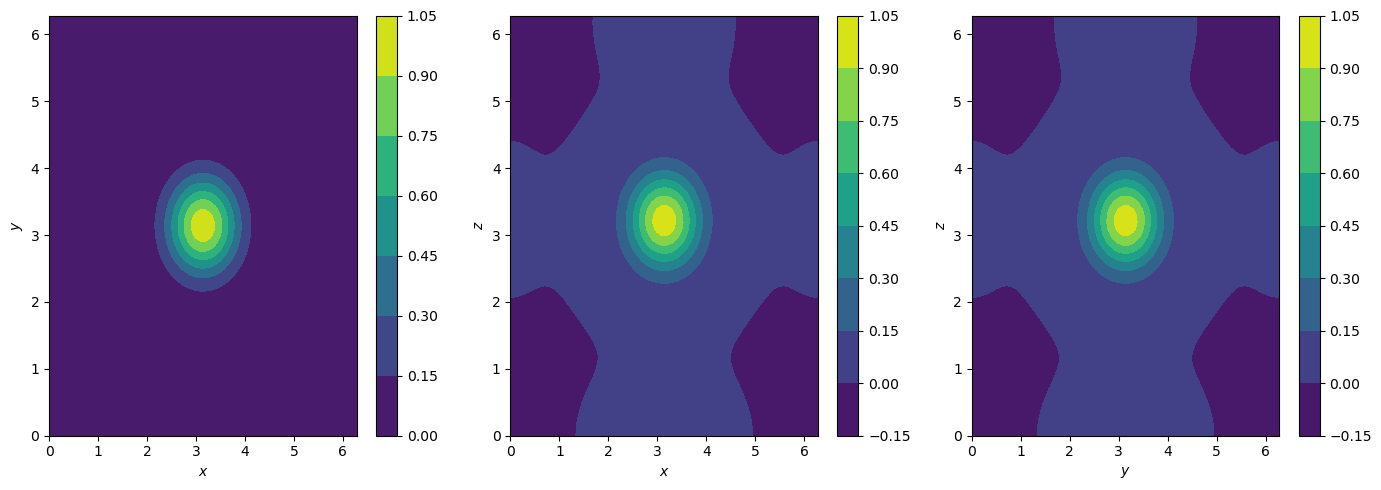

In [6]:
plot(x, y, z, P_a)

In [36]:
Ns = np.array([16, 32, 64, 128, 256])
errors = np.zeros(len(Ns))
times = np.zeros(len(Ns))
dzs = np.zeros(len(Ns))
N_exp = 5
for i in range(len(Ns)):
    N = Ns[i]
    print("Computing for N =", N)
    x, y, z, P, F = experiment(N, N, N)
    start = time.time()
    for e in range(N_exp):
        P_a = fftfd(F, x, y, z)
    end = time.time()
    dzs[i] = z[1] - z[0]    
    errors[i] = np.linalg.norm(P.flatten() - P_a.flatten()) / np.linalg.norm(P.flatten())
    times[i] = (end - start) / N_exp

Computing for N = 16
Computing for N = 32
Computing for N = 64
Computing for N = 128
Computing for N = 256


[]

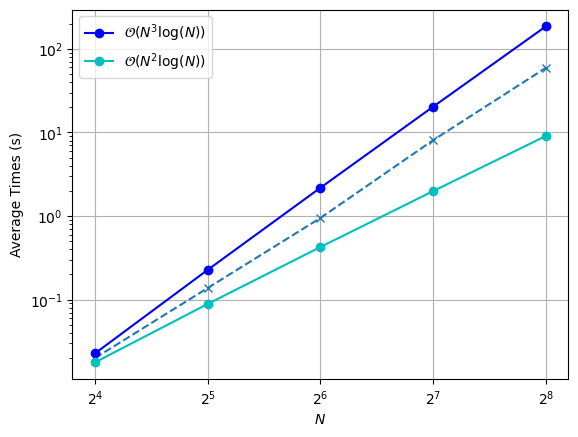

In [40]:
plt.plot(Ns, times, 'x--')
plt.plot(Ns, Ns ** 3 * np.log(Ns) / 5e5, 'b-o', label=r'$\mathcal{O}(N^3 \log(N))$')
plt.plot(Ns, Ns ** 2 * np.log(Ns) / 4e4, 'c-o', label=r'$\mathcal{O}(N^2 \log(N))$')
plt.grid(True)
plt.yscale('log')
plt.xlabel(r'$N$')
plt.ylabel('Average Times (s)')
plt.xscale('log', base=2)
plt.legend()
plt.plot()

[]

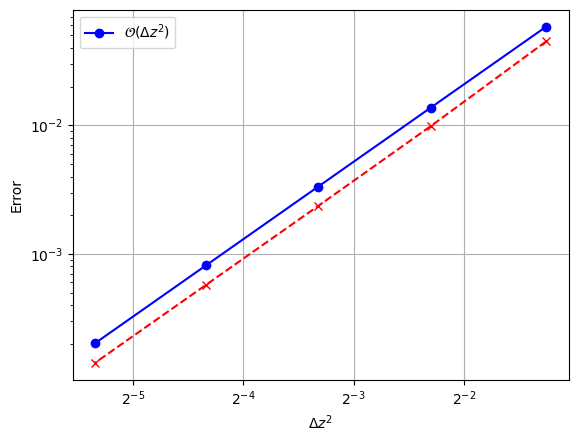

In [39]:
plt.plot(dzs, errors, 'x--r')
plt.plot(dzs, dzs ** 2 / 3, 'b-o', label=r'$\mathcal{O}(\Delta z^2)$')
plt.grid(True)
plt.yscale('log')
plt.xlabel(r'$\Delta z^2$')
plt.ylabel('Error')
plt.xscale('log', base=2)
plt.legend()
plt.plot()

In [48]:
print("$N$ & Time (s)  \\\\")
for i in range(len(Ns)):
    print("%d & $%.2f$ \\\\" % (Ns[i], times[i]))

print("N Error")
for i in range(len(Ns)):
    print("%d  %.6f" % (Ns[i], times[i]))

$N$ & Time (s)  \\
16 & $0.02$ \\
32 & $0.14$ \\
64 & $0.95$ \\
128 & $8.08$ \\
256 & $59.36$ \\
N Error
16  0.019964
32  0.137509
64  0.947584
128  8.084601
256  59.356002


In [50]:
print("$\Delta z$ & Error  \\\\")
for i in range(len(Ns)):
    print("$%.2f$ & $%.8f$ \\\\" % (dzs[i], errors[i]))
print("dz Error")
for i in range(len(Ns)):
    print("%.8f  %.8f" % (dzs[i], errors[i]))

$\Delta z$ & Error  \\
$0.42$ & $0.04489342$ \\
$0.20$ & $0.00983079$ \\
$0.10$ & $0.00234570$ \\
$0.05$ & $0.00057523$ \\
$0.02$ & $0.00014256$ \\
dz Error
0.41887902  0.04489342
0.20268340  0.00983079
0.09973310  0.00234570
0.04947390  0.00057523
0.02463994  0.00014256


---